In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__
import os
import re
import Thermobar as pt

In [2]:
def calculate_HB_area(df):
    HB_diad=(df['HB2_Area']+df['HB1_Area'])/((df['Diad1_Voigt_Area']+df['Diad2_Voigt_Area']))
    return HB_diad

In [3]:
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels

In [4]:
def extract_temperature(filename):
    match = re.search(r'(\d+)C', filename)
    if match:
        return int(match.group(1))
    else:
        return None

## Now lets load the tidy dataframe from the supplement

In [5]:
df=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\Raman technical paper\Supporting_information_Draft1.xlsx',
                 sheet_name='Combined_power_heating_series')

df_heat=df.loc[df['Series_Type']=='heat']
df_power=df.loc[df['Series_Type']=='power']

## Need to define the others. 

In [6]:
df_heat['Series_Name'].unique()

array(['B30_c1_heat', 'B23_c3_heat', '11i_c2_heat', 'FG04-13-1_heat',
       '101B_heat', '101C_heat', 'FG04-A3_FI1_heat', 'FG04-A3_MI1_heat',
       'FG04-A3_FI2_heat', 'FG04-A3_MI2_heat'], dtype=object)

## Equations for densimeters

In [7]:
def rho_CO2(Delta, T_K):

    TR=T_K/(31.1+273.15)
    # Define the coefficients A_ij as a dictionary (i, j): value
    A = {
        (0, 0): -1.1429,
        (1, 0): -0.3144,
        (0, 1):  0.4461,
        (0, 2): -0.02296,
        (1, 1):  0.1529
    }

    # Compute rho_CO2 as per the equation
    rho = 0
    for (i, j), value in A.items():
        rho += value * (TR ** i) * ((Delta - 100) ** j)

    return rho

In [8]:
def calculate_CO2_rho_H21(split, T_K):
    T_C=T_K-273.15
    a=-61821.3575
    b=-3.3585*10**-4
    c=1.56567*10**-8
    d=1781.1957586
    e=-17.112171653
    f=0.0548181541
    g=0.00119219
    h=-0.0000112203
    i=3.12805*10**-6
    j=-1.02847*10**-46

    CO2_dens=a + b*T_C**2 + c*T_C**3 + d*split +   e * split**2 + f* split**3 + g*split*T_C + h*split**2*T_C + i*split*T_C**2 + j*np.exp(split)

    return CO2_dens


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import Thermobar as pt

# --- Setup ---
Delta = np.linspace(102.8, 105, 200)
Temps_C = np.linspace(37, 250, 100)

# --- Load or assume merged df is available as df_heat ---
# Mapping Series_Name to (plot label, color)
label_color_map = {
    '11i_c2_heat':      ('IS',      'gold'),
    'B23_c3_heat':      ('B23',     'seagreen'),
    'FG04-13-1_heat':   ('A13',     'darkviolet'),
    'B30_c1_heat':      ('B30',     'black'),
    '101B_heat':        ('FIB',     'cyan'),
    'FG04-A3_FI1_heat': ('Fogo_FI', 'darkred'),
}

# --- Create full_data using df_heat ---
full_data = []
for series_label, (plot_label, color) in label_color_map.items():
    sub_df = df_heat[df_heat['Series_Name'] == series_label]
    full_data.append((plot_label, color, sub_df['T (C)'], sub_df['Density g/cm3']))

# --- Separate IS from the rest ---
IS_label, IS_color, IS_T, IS_dens = full_data[0]
rest_data = full_data[1:]

# --- Function to calculate stats and extract values ---
def get_stats_and_val(T, dens):
    stats = pt.calculate_R2(T, dens)
    rho_37 = stats['Grad'][0] * 37 + stats['Int'].item()
    stats_diff = pt.calculate_R2(T, rho_37 - dens)
    grad = stats['Grad']
    grad_err = stats['Grad_err']
    return rho_37, stats_diff, grad, grad_err

# --- Process IS first ---
rho_37_IS, stats_diff_IS, grad_IS, grad_err_IS = get_stats_and_val(IS_T, IS_dens)
processed = [{
    'label': IS_label,
    'color': IS_color,
    'T': IS_T,
    'dens': IS_dens,
    'rho_37': rho_37_IS,
    'stats': stats_diff_IS,
    'grad': grad_IS,
    'grad_err': grad_err_IS
}]

# --- Process and sort the rest ---
rest_processed = []
for label, color, T, dens in rest_data:
    rho_37, stats_diff, grad, grad_err = get_stats_and_val(T, dens)
    rest_processed.append({
        'label': label,
        'color': color,
        'T': T,
        'dens': dens,
        'rho_37': rho_37,
        'stats': stats_diff,
        'grad': grad,
        'grad_err': grad_err
    })

# --- Sort the rest by rho_37 ---
rest_processed_sorted = sorted(rest_processed, key=lambda d: d['rho_37'])

# --- Combine full ordered data ---
all_data = processed + rest_processed_sorted

# --- Create summary table ---
summary_data = {
    'Dataset': [d['label'] for d in all_data],
    'Density 37 (g/cm³)': [d['rho_37'] for d in all_data],
    'Gradient (g/cm³/°C)': [d['grad'] for d in all_data],
    'Gradient error (g/cm³/°C)': [d['grad_err'] for d in all_data],
    'Difference (g/cm³)': [d['grad'] * (70 - 37) for d in all_data],
    'Difference error (g/cm³)': [d['grad_err'] * (70 - 37) for d in all_data]
}
summary_df = pd.DataFrame(summary_data)


## Figure 11 a-c

C:\Users\penny\AppData\Local\Temp\ipykernel_28112\791193712.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('magma', len(Temps_C)+1)


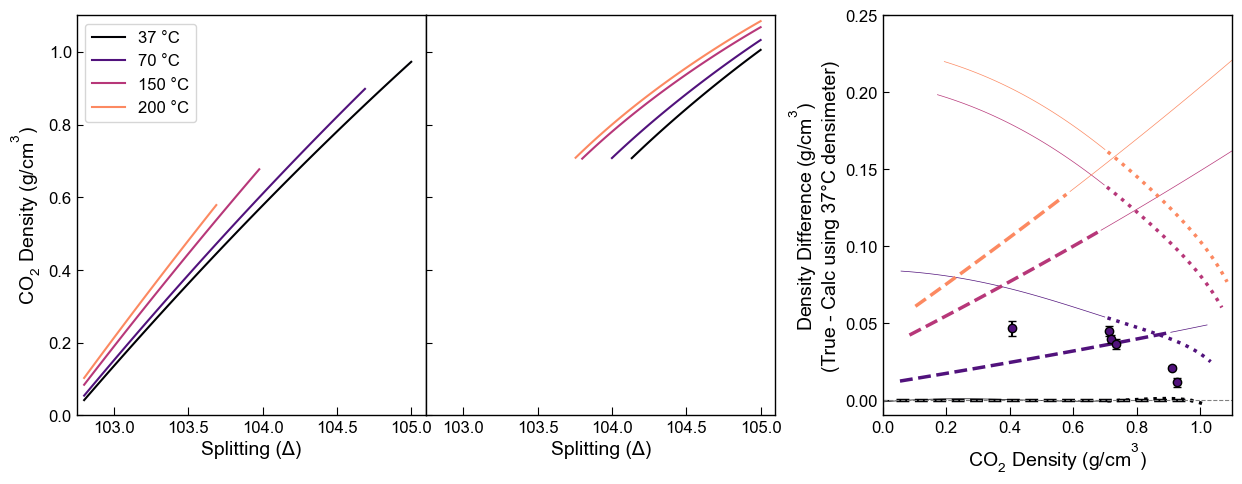

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

# Define Delta range for plotting
Delta = np.linspace(102.8, 105, 100)
Temps_C = [37, 70, 150, 200]

# Set up color map
cmap = cm.get_cmap('magma', len(Temps_C)+1)
colors = cmap.colors if hasattr(cmap, 'colors') else [cmap(i / len(Temps_C)) for i in range(len(Temps_C))]

# Create figure and GridSpec
fig = plt.figure(figsize=(13.4, 5))
gs = GridSpec(nrows=1, ncols=4, width_ratios=[0.8, 0.8, 0.1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[3])

# Fit at 37 C for baseline polynomial
T_fit_C = 37
T_fit_K = 273.15 + T_fit_C
x_fit = np.linspace(102.8, 105, 200)
y_fit_orig = rho_CO2(x_fit, T_K=T_fit_K)
p_orig = np.poly1d(np.polyfit(x_fit, y_fit_orig, 3))

y_fit_H21 = calculate_CO2_rho_H21(split=x_fit, T_K=T_fit_K)
p_H21 = np.poly1d(np.polyfit(x_fit, y_fit_H21, 3))

## Actual plotting loop
for i, T_C in enumerate(Temps_C):
    T_K = 273.15 + T_C

    # === ORIGINAL MODEL ===
    Rho_orig = rho_CO2(Delta, T_K=T_K)
    EOS_check = pf.calculate_P_for_rho_T(CO2_dens_gcm3=Rho_orig, T_K=T_K)
    Keep_orig = EOS_check['P_MPa'].between(1, 50)

    # Plot full on ax1
    ax1.plot(Delta[Keep_orig], Rho_orig[Keep_orig], '-', color=colors[i], label=f'{T_C} °C')
    
    # Plot full on ax3: split into valid and extrapolated
    ax3.plot(Rho_orig[Keep_orig], Rho_orig[Keep_orig] - p_orig(Delta[Keep_orig]), '--', color=colors[i], linewidth=2.5)

    NotKeep = ~Keep_orig
    if NotKeep.any():
        ax3.plot(Rho_orig[NotKeep], Rho_orig[NotKeep] - p_orig(Delta[NotKeep]), '-', color=colors[i], linewidth=0.5)



    # === H21 MODEL ===
    Rho_H21 = calculate_CO2_rho_H21(split=Delta, T_K=T_K)
    Keep_H21 = (Rho_H21 > 0.7) & (Rho_H21 < 1.2)

    # Plot full on ax2
    ax2.plot(Delta[Keep_H21], Rho_H21[Keep_H21], '-', color=colors[i])

    # Plot on ax3: split into valid and extrapolated
    ax3.plot(Rho_H21[Keep_H21], Rho_H21[Keep_H21] - p_H21(Delta[Keep_H21]), ':', color=colors[i], linewidth=2.5)

    NotKeep_H21 = ~Keep_H21
    if NotKeep_H21.any():
        ax3.plot(Rho_H21[NotKeep_H21], Rho_H21[NotKeep_H21] - p_H21(Delta[NotKeep_H21]),
                 '-', color=colors[i], linewidth=0.5)

 

# Axis labels
ax1.set_xlabel('Splitting (Δ)')
ax1.set_ylabel('CO$_2$ Density (g/cm$^3$)')
ax1.legend()

ax2.set_xlabel('Splitting (Δ)')
ax2.tick_params(labelleft=False)

ax3.set_xlabel('CO$_2$ Density (g/cm$^3$)')
ax3.set_ylabel('Density Difference (g/cm$^3$)\n(True - Calc using 37°C densimeter)')
ax3.axhline(0, linestyle='--', color='gray', linewidth=0.8)

# Limits
for ax in [ax1, ax2]:
    ax.set_xlim([102.75, 105.1])
    ax.set_ylim([0, 1.1])
    ax.set_xticks([103, 103.5, 104, 104.5, 105])

# Adjust layout manually to remove space between ax1 and ax2
fig.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.15, wspace=0.0)
ax3.set_position([
    ax2.get_position().x1 + 0.08,  # x
    ax2.get_position().y0,        # y
    ax2.get_position().width,     # width
    ax2.get_position().height     # height
])

idx_70 = Temps_C.index(70)
color_for_70 = colors[idx_70]

# Predicted change: gradient * (70 - 37)
delta_T = 70 - 37
grad_chec = summary_df['Gradient (g/cm³/°C)'] * delta_T
grad_err_chec = summary_df['Gradient error (g/cm³/°C)'] * delta_T

ax3.errorbar(
    summary_df['Density 37 (g/cm³)'],
    -grad_chec,
    yerr=grad_err_chec,
    fmt='ok',
    mfc=color_for_70,
    capsize=3,
    label='Predicted Δρ (37→70 °C)'
)

ax3.set_xlim([0, 1.1])
ax3.set_ylim([-0.01, 0.25])
#fig.tight_layout()
fig.savefig('Temp_Sensitivity_FINAL.png', dpi=300, transparent=True)


C:\Users\penny\AppData\Local\Temp\ipykernel_28112\3635385821.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(Temps_C))


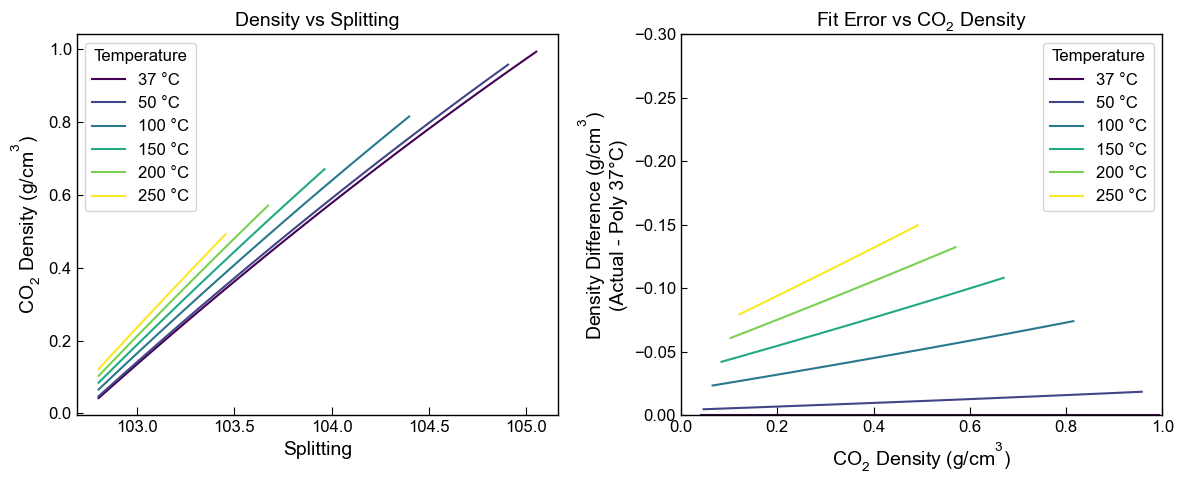

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define Delta range for plotting
Delta = np.linspace(102.8, 110, 100)

# Define list of temperatures in Celsius for first plot
Temps_C = [37, 50, 100, 150, 200, 250]

# Set up color map
cmap = cm.get_cmap('viridis', len(Temps_C))
colors = cmap.colors if hasattr(cmap, 'colors') else [cmap(i/len(Temps_C)) for i in range(len(Temps_C))]

# Prepare figure: 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

# First: fit polynomial at 37 °C
T_fit_C = 37
T_fit_K = 273.15 + T_fit_C
x_fit = np.linspace(102.8, 105, 100)
y_fit = rho_CO2(x_fit, T_K=T_fit_K)

degree = 3  # You can adjust degree!
coeffs = np.polyfit(x_fit, y_fit, degree)
p = np.poly1d(coeffs)

# Loop over temperatures for main plot + second plot
for i, T_C in enumerate(Temps_C):
    T_K = 273.15 + T_C
    
    # Calculate density on full Delta range
    Rho_CO2_full = rho_CO2(Delta, T_K=T_K)
    
    # Filter to valid pressures
    EOS_check = pf.calculate_P_for_rho_T(CO2_dens_gcm3=Rho_CO2_full, T_K=T_K)
    Keep = EOS_check['P_MPa'].between(1, 50)
    
    # Plot main density vs Delta curve
    ax1.plot(Delta[Keep], Rho_CO2_full[Keep], '-', color=colors[i], label=f'{T_C} °C')
    
    # Now use 37 °C polynomial to predict
    Rho_poly_at_T = p(Delta)
    
    # Plot density vs difference
    ax2.plot(Rho_CO2_full[Keep],  Rho_poly_at_T[Keep]-Rho_CO2_full[Keep], 
             '-', color=colors[i], label=f'{T_C} °C')

# Labeling main plot
ax1.set_xlabel('Splitting')
ax1.set_ylabel('CO$_2$ Density (g/cm$^3$)')
ax1.legend(title='Temperature')
ax1.set_title('Density vs Splitting')

# Labeling difference plot
ax2.set_xlabel('CO$_2$ Density (g/cm$^3$)')
ax2.set_ylabel('Density Difference (g/cm$^3$)\n(Actual - Poly 37°C)')
ax2.axhline(0, linestyle='--', color='gray', linewidth=0.8)
ax2.legend(title='Temperature')
ax2.set_title('Fit Error vs CO$_2$ Density')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, -0.3])

# Tidy layout
plt.tight_layout()
plt.show()



## heating series vs. temperatures

0.7198743577547398
0.7122507618035706
0.7344676354397762
0.9093414910062642
0.925976335983574


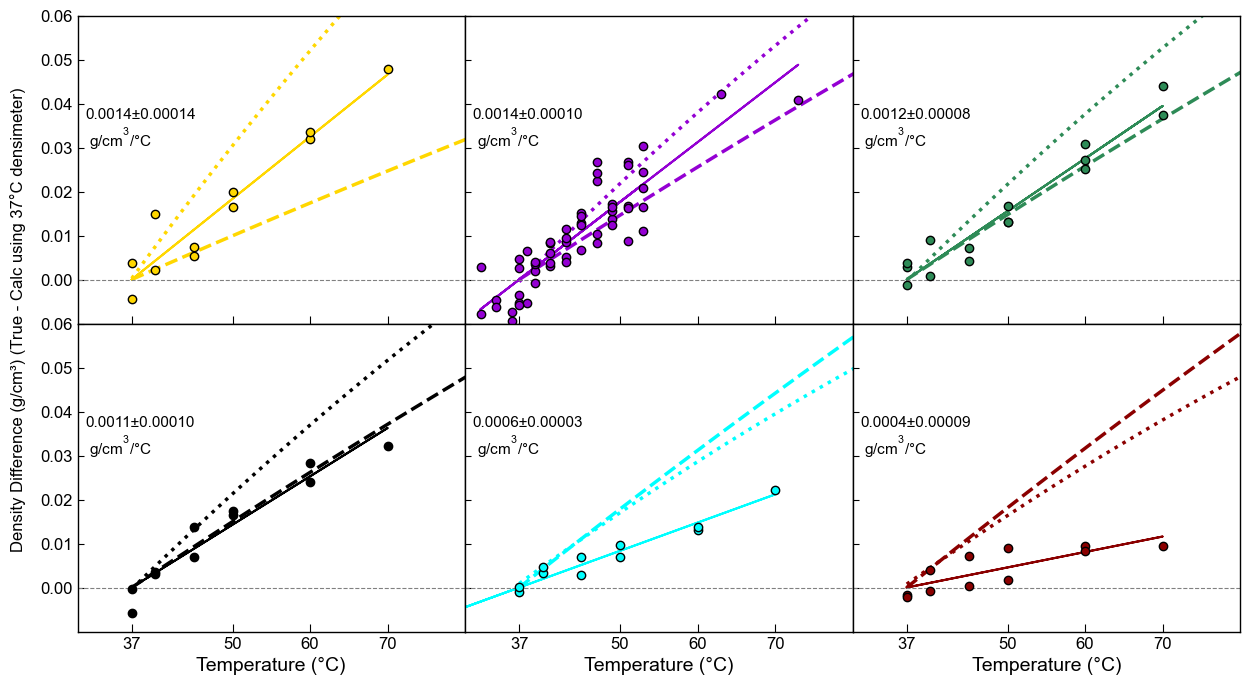

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d

# --- Setup ---
Delta = np.linspace(102.8, 105, 200)
Temps_C = np.linspace(37, 250, 100)

# --- Full dataset: labels, colors, data ---
# Define label-color pairs for each series
label_color_map = {
    '11i_c2_heat':      ('IS',      'gold'),
    'B23_c3_heat':      ('B23',     'seagreen'),
    'FG04-13-1_heat':   ('A13',     'darkviolet'),
    'B30_c1_heat':      ('B30',     'black'),
    '101B_heat':        ('FIB',     'cyan'),
    'FG04-A3_FI1_heat': ('Fogo_FI', 'darkred'),
}

# Construct full_data from df_heat
full_data = []
for series_label, (plot_label, color) in label_color_map.items():
    sub_df = df_heat[df_heat['Series_Name'] == series_label]
    full_data.append((plot_label, color, sub_df['T (C)'], sub_df['Density g/cm3']))

# --- Separate IS from the rest ---
IS_label, IS_color, IS_T, IS_dens = full_data[0]
rest_data = full_data[1:]

# --- Calculate ρ at 37 °C and regress differences ---
def get_stats_and_val(T, dens):
    stats = pt.calculate_R2(T, dens)
    rho_37 = stats['Grad'][0] * 37 + stats['Int'].item()
    stats_diff = pt.calculate_R2(T, rho_37 - dens)
    return rho_37, stats_diff

# --- Process IS first ---
rho_37_IS, stats_diff_IS = get_stats_and_val(IS_T, IS_dens)
processed = [{
    'label': IS_label,
    'color': IS_color,
    'T': IS_T,
    'dens': IS_dens,
    'rho_37': rho_37_IS,
    'stats': stats_diff_IS
}]


# --- Process and sort the rest ---
rest_processed = []
for label, color, T, dens in rest_data:
    rho_37, stats_diff = get_stats_and_val(T, dens)
    rest_processed.append({
        'label': label,
        'color': color,
        'T': T,
        'dens': dens,
        'rho_37': rho_37,
        'stats': stats_diff
    })
    print(rho_37)

# --- Sort the rest by rho_37 ---
rest_processed_sorted = sorted(rest_processed, key=lambda d: d['rho_37'])

# --- Combine full ordered data ---
all_data = processed + rest_processed_sorted

# --- Collect ρ values at 37 °C for modeling ---
vals_at_37 = np.array([d['rho_37'] for d in all_data])
Densities = vals_at_37.copy()

# --- Initialize difference arrays ---
density_diffs_orig = np.full((len(Densities), len(Temps_C)), np.nan)
density_diffs_H21  = np.full((len(Densities), len(Temps_C)), np.nan)

# --- Loop over temperatures to compute modeled differences ---
for iT, T_C in enumerate(Temps_C):
    T_K = 273.15 + T_C

    Rho_CO2_actual = rho_CO2(Delta, T_K=T_K)
    Rho_poly = p(Delta)

    interp_actual = interp1d(Rho_CO2_actual, Delta, bounds_error=False, fill_value='extrapolate')
    interp_poly = interp1d(Delta, Rho_poly, bounds_error=False, fill_value='extrapolate')

    Rho_CO2_H21 = calculate_CO2_rho_H21(Delta, T_K=T_K)
    Rho_poly_H21 = p_H21(Delta)

    interp_actual_H21 = interp1d(Rho_CO2_H21, Delta, bounds_error=False, fill_value='extrapolate')
    interp_poly_H21 = interp1d(Delta, Rho_poly_H21, bounds_error=False, fill_value='extrapolate')

    for iD, D_target in enumerate(Densities):
        if D_target < np.min(Rho_CO2_actual) or D_target > np.max(Rho_CO2_actual):
            density_diffs_orig[iD, iT] = np.nan
        else:
            Delta_target = interp_actual(D_target)
            Poly_at_target = interp_poly(Delta_target)
            density_diffs_orig[iD, iT] = D_target - Poly_at_target

        if D_target < np.min(Rho_CO2_H21) or D_target > np.max(Rho_CO2_H21):
            density_diffs_H21[iD, iT] = np.nan
        else:
            Delta_target_H21 = interp_actual_H21(D_target)
            Poly_at_target_H21 = interp_poly_H21(Delta_target_H21)
            density_diffs_H21[iD, iT] = D_target - Poly_at_target_H21

# --- Plot ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
axes = axes.flatten()  # Flatten 2D array into 1D for easier iteration


for i, ax in enumerate(axes):
    d = all_data[i]
    label, color, T_exp, dens_exp, rho_37, stats_exp = d['label'], d['color'], d['T'], d['dens'], d['rho_37'], d['stats']
    diff_exp = rho_37 - dens_exp

    # Model curves
    ax.plot(Temps_C, density_diffs_orig[i, :], '--', color=color, linewidth=2.5,
            label=f'{label} ({rho_37:.3f} g/cm³)') # this is Sublet, dashed lines
    ax.plot(Temps_C, density_diffs_H21[i, :], ':', color=color, linewidth=2.5) # This is H2021, dashed lines. 

    # Experimental data
    ax.plot(T_exp, diff_exp, 'ok', mfc=color, zorder=100)
    ax.plot(stats_exp['x_pred'], stats_exp['y_pred'], '-', color=color)

    # Annotation
    ax.annotate(f"{stats_exp['Grad'][0]:.4f}±{stats_exp['Grad_err']:.5f}\n g/cm$^3$/°C", 
                xy=(0.02, 0.7), xycoords='axes fraction',
                ha='left', va='top', fontsize=11, color='k')

    
    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    ax.set_xlim([30, 80])
    ax.set_ylim([-0.01, 0.06])
    #ax.legend(fontsize=8, loc='upper left')

axes[3].set_xlabel('Temperature (°C)')
axes[4].set_xlabel('Temperature (°C)')
axes[5].set_xlabel('Temperature (°C)')
fig.text(0.08, 0.5, 'Density Difference (g/cm³) (True - Calc using 37°C densimeter)',
         va='center', rotation='vertical', fontsize=12)
axes[0].set_xticks([37, 50, 60, 70])
axes[0].set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])

plt.show()
fig.savefig('Heating_Responses_sorted.png', dpi=300, transparent=True)


## Making heating alignement figure

C:\Users\penny\AppData\Local\Temp\ipykernel_28112\3263548300.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


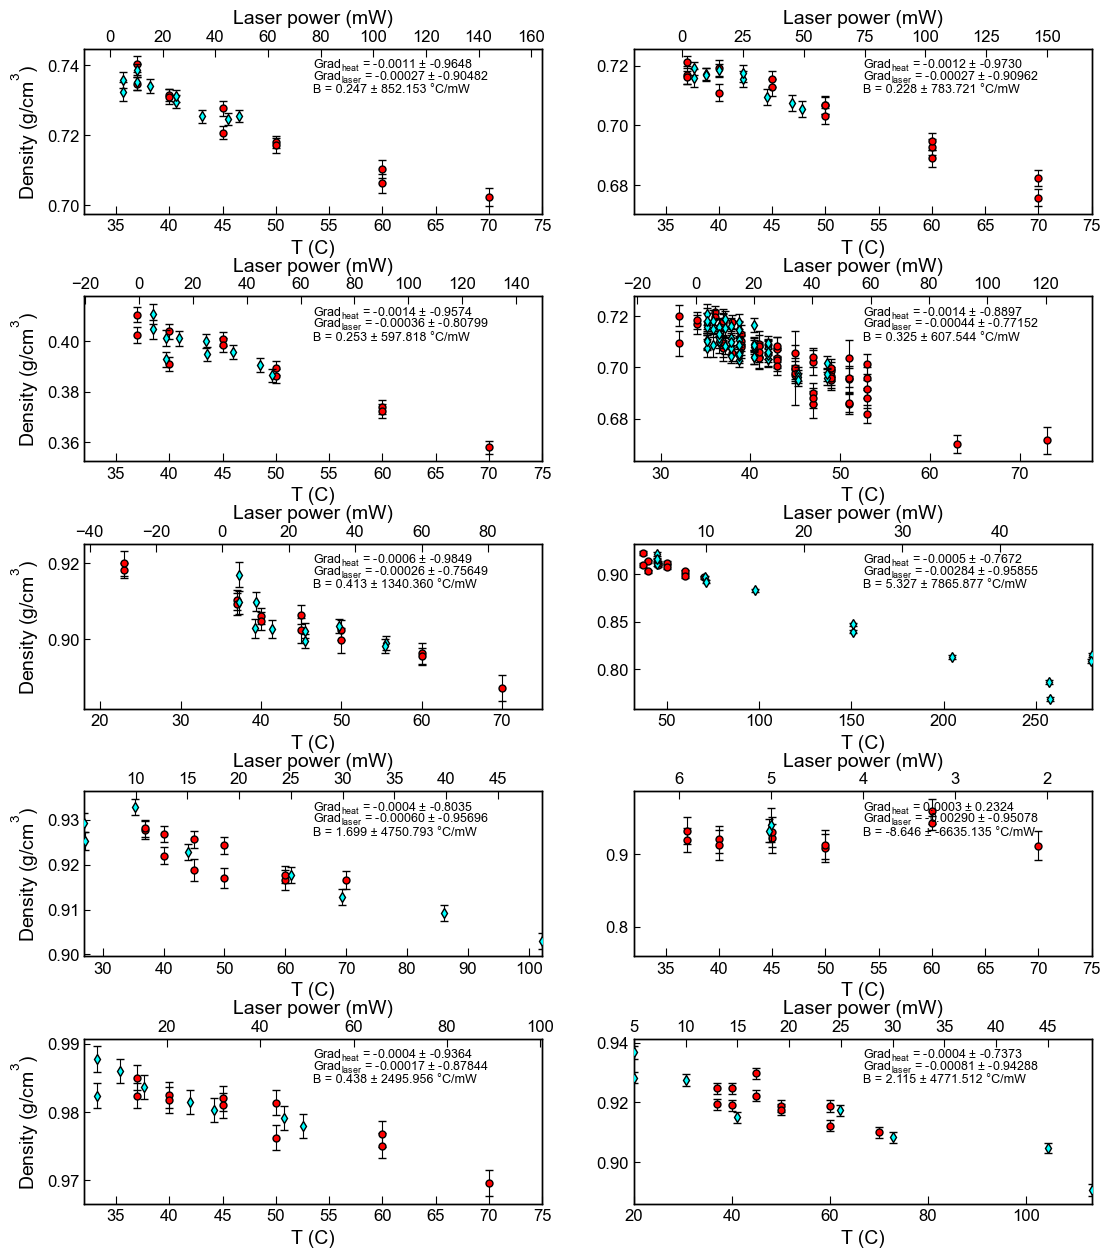

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

series_names = [
    'B30_c1',
    'B23_c3',
    '11i_c2',
    'FG04-13-1',
    '101B',
    '101C',
    'FG04-A3_FI1',
    'FG04-A3_MI1',
    'FG04-A3_FI2',
    'FG04-A3_MI2',
]

fig, axes = plt.subplots(5, 2, figsize=(13, 15), gridspec_kw={'hspace': 0.5})
axes = axes.flatten()

def compute_axes(T_heat, P_power, scale, offset):
    T_min_pad = T_heat.min() - 5
    T_max_pad = T_heat.max() + 5
    T_from_P_min = scale * P_power.min() + offset
    T_from_P_max = scale * P_power.max() + offset
    T_final_min = min(T_min_pad, T_from_P_min)
    T_final_max = max(T_max_pad, T_from_P_max)
    P_final_min = (T_final_min - offset) / scale
    P_final_max = (T_final_max - offset) / scale
    return (T_final_min, T_final_max), (P_final_min, P_final_max)

for i, name in enumerate(series_names):
    ax = axes[i]
    twin_ax = ax.twiny()

    heat = df_heat[df_heat['Series_Name'].str.contains(name)]
    power = df_power[df_power['Series_Name'].str.contains(name)]

    # === Heating data ===
    ax.errorbar(heat['T (C)'], heat['Density g/cm3'],
                yerr=heat['σ Density g/cm3'],
                fmt='o', ecolor='k', elinewidth=0.8,
                mfc='red', ms=5, mec='k', capsize=3)

    # === Power data ===
    twin_ax.errorbar(power['power (mW)'], power['Density g/cm3'],
                     yerr=power['σ Density g/cm3'],
                     fmt='d', ecolor='k', elinewidth=0.8,
                     mfc='cyan', ms=5, mec='k', capsize=3, zorder=100)

    # === Fit heating ===
    x_heat = heat['T (C)']
    y_heat = heat['Density g/cm3']
    slope_h, intercept_h, stderr_h = linregress(x_heat, y_heat)[:3]

    # === Fit power ===
    x_power = power['power (mW)']
    y_power = power['Density g/cm3']
    slope_p, intercept_p, stderr_p = linregress(x_power, y_power)[:3]

    # === Calculate B and error ===
    B = slope_p / slope_h
    B_err = B * np.sqrt((stderr_p / slope_p)**2 + (stderr_h / slope_h)**2)

    # === Align axes ===
    T_equiv = (y_power - intercept_h) / slope_h
    scale_fit, offset_fit = linregress(x_power, T_equiv)[:2]

    (Tmin, Tmax), (Pmin, Pmax) = compute_axes(x_heat, x_power, scale_fit, offset_fit)
    ax.set_xlim(Tmin, Tmax)
    twin_ax.set_xlim(Pmin, Pmax)

    # === Labels ===
    ax.set_xlabel('T (C)')
    if i % 2 == 0:
        ax.set_ylabel('Density (g/cm$^3$)')
    twin_ax.set_xlabel('Laser power (mW)')

    # === Annotations ===
    ax.annotate(f"Grad$_{{heat}}$ = {slope_h:.4f} ± {stderr_h:.4f}",
                xy=(0.5, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=9)
    ax.annotate(f"Grad$_{{laser}}$ = {slope_p:.5f} ± {stderr_p:.5f}",
                xy=(0.5, 0.88), xycoords='axes fraction', ha='left', va='top', fontsize=9)
    ax.annotate(f"B = {B:.3f} ± {B_err:.3f} °C/mW",
                xy=(0.5, 0.79), xycoords='axes fraction', ha='left', va='top', fontsize=9)

plt.tight_layout()
fig.savefig('All_B_panels_aligned.png', dpi=300)


In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import linregress

# series_names = [
#     'B30_c1',
#     'B23_c3',
#     '11i_c2',
#     'FG04-13-1',
#     '101B',
#     '101C',
#     'FG04-A3_FI1',
#     'FG04-A3_MI1',
#     'FG04-A3_FI2',
#     'FG04-A3_MI2',
# ]

# fig, axes = plt.subplots(5, 2, figsize=(13, 15), gridspec_kw={'hspace': 0.5})
# axes = axes.flatten()

# for i, name in enumerate(series_names):
#     heat = df_heat[df_heat['Series_Name'].str.contains(name)]
#     power = df_power[df_power['Series_Name'].str.contains(name)]
    
#     ax_main = axes[i]
#     ax_twin = ax_main.twiny()
    
#     # === HEATING ===
#     ax_main.errorbar(heat['T (C)'], heat['Density g/cm3'],
#                      xerr=0, yerr=heat['σ Density g/cm3'],
#                      fmt='o', ecolor='k', elinewidth=0.8, mfc='red', ms=5, mec='k', capsize=3)

#     #ax_main.set_title(name.replace('_power', ''))
#     ax_main.set_xlabel('T (C)')
#     ax_main.set_ylabel('Density (g/cm$^3$)')

#     # === POWER ===
#     ax_twin.errorbar(power['power (mW)'], power['Density g/cm3'],
#                      xerr=0, yerr=power['σ Density g/cm3'],
#                      fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=5, mec='k', capsize=3, zorder=100)
#     ax_twin.set_xlabel('Laser power (mW)')

#     # === FIT HEATING ===
#     xh = heat['T (C)']
#     yh = heat['Density g/cm3']
#     res_h = linregress(xh, yh)
#     m_h, b_h, err_h = res_h.slope, res_h.intercept, res_h.stderr

#     # === FIT POWER ===
#     xp = power['power (mW)']
#     yp = power['Density g/cm3']
#     res_p = linregress(xp, yp)
#     m_p, b_p, err_p = res_p.slope, res_p.intercept, res_p.stderr

#     # === B and error ===
#     B = m_p / m_h
#     B_err = B * np.sqrt((err_p / m_p)**2 + (err_h / m_h)**2)

#     # === Align laser x-axis to temperature equivalent ===
#     T_equiv = (yp - b_h) / m_h
#     m_align, b_align, *_ = linregress(xp, T_equiv)
#     Tlim = ax_main.get_xlim()
#     ax_twin.set_xlim([(Tlim[0] - b_align) / m_align,
#                       (Tlim[1] - b_align) / m_align])
    
#     ## other way
#     # === Function to compute consistent axis limits ===


#     # === Calculate and apply limits ===
#     (Tlim1_min, Tlim1_max), (Plim1_min, Plim1_max) = compute_axes(T_heat1, P_power1, scale1, offset1)
#     (Tlim2_min, Tlim2_max), (Plim2_min, Plim2_max) = compute_axes(T_heat2, P_power2, scale2, offset2)

#     ax1.set_xlim(Tlim1_min, Tlim1_max)
#     ax2.set_xlim(Tlim2_min, Tlim2_max)
#     ax4.set_xlim(Plim1_min, Plim1_max)
#     ax3.set_xlim(Plim2_min, Plim2_max)

#     # === Annotations ===
#     ax_twin.annotate(f"Grad$_{{heat}}$ = {m_h:.4f} ± {err_h:.4f}\n"
#                      f"Grad$_{{laser}}$ = {m_p:.5f} ± {err_p:.5f}\n"
#                      f"B = {B:.3f} ± {B_err:.3f} °C/mW",
#                      xy=(0.4, 0.88), xycoords='axes fraction',
#                      ha='left', va='top', fontsize=10)

# plt.tight_layout()
# fig.savefig('All_Temp_Laser_10panel.png', dpi=300)


## Plots for Supporting info-
- looping through all the laser power series that also have heating series

In [15]:
labels_power = [
    'B30_c1_power',
    'B23_c3_power',
    '11i_c2_power',
    'FG04-13-1_power',
    '101B_power',
    '101C_power',
    'FG04-A3_FI1_power',
    'FG04-A3_MI1_power',
    'FG04-A3_FI2_power',
    'FG04-A3_MI2_power',
    
]

labels_heat = [
    'B30_c1_heat',
    'B23_c3_heat',
    '11i_c2_heat',
    'FG04-13-1_heat',
    '101B_heat',
    '101C_heat',
    'FG04-A3_FI1_heat',
    'FG04-A3_MI1_heat',
    'FG04-A3_FI2_heat',
    'FG04-A3_MI2_heat',
    
]

## Supplement figure for power series

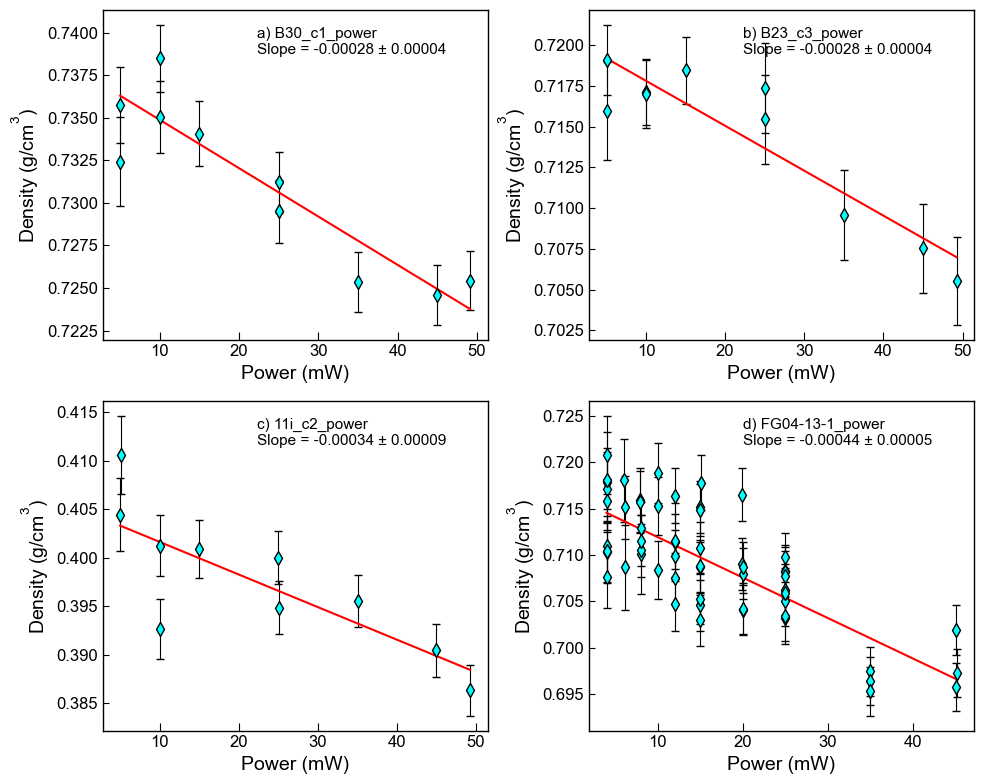

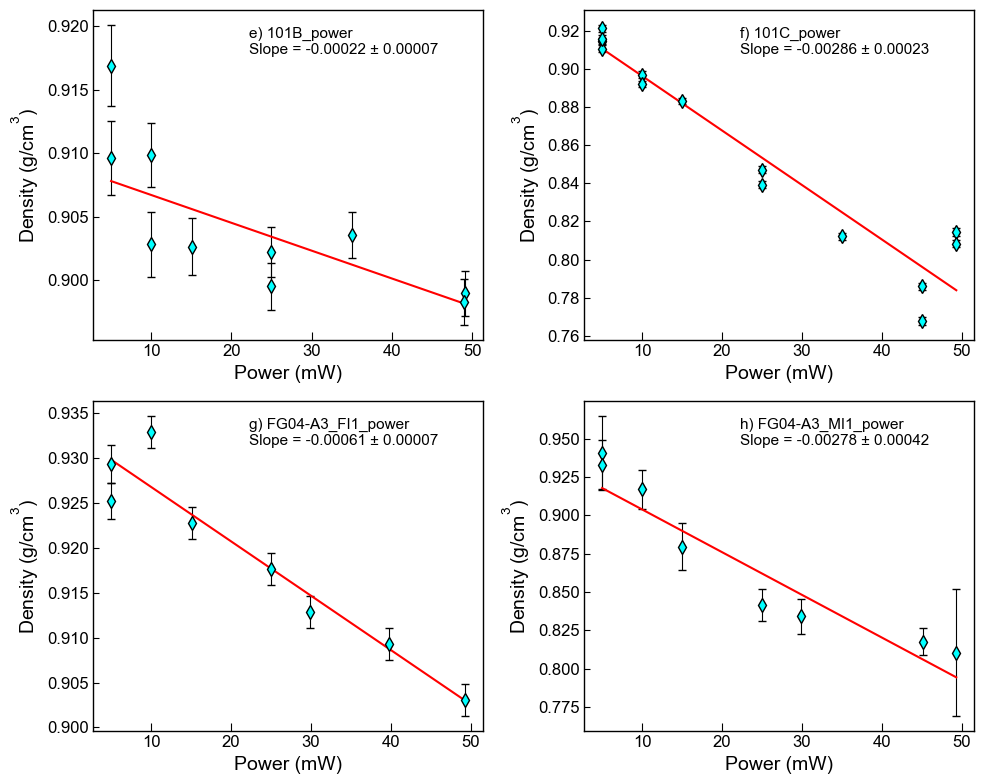

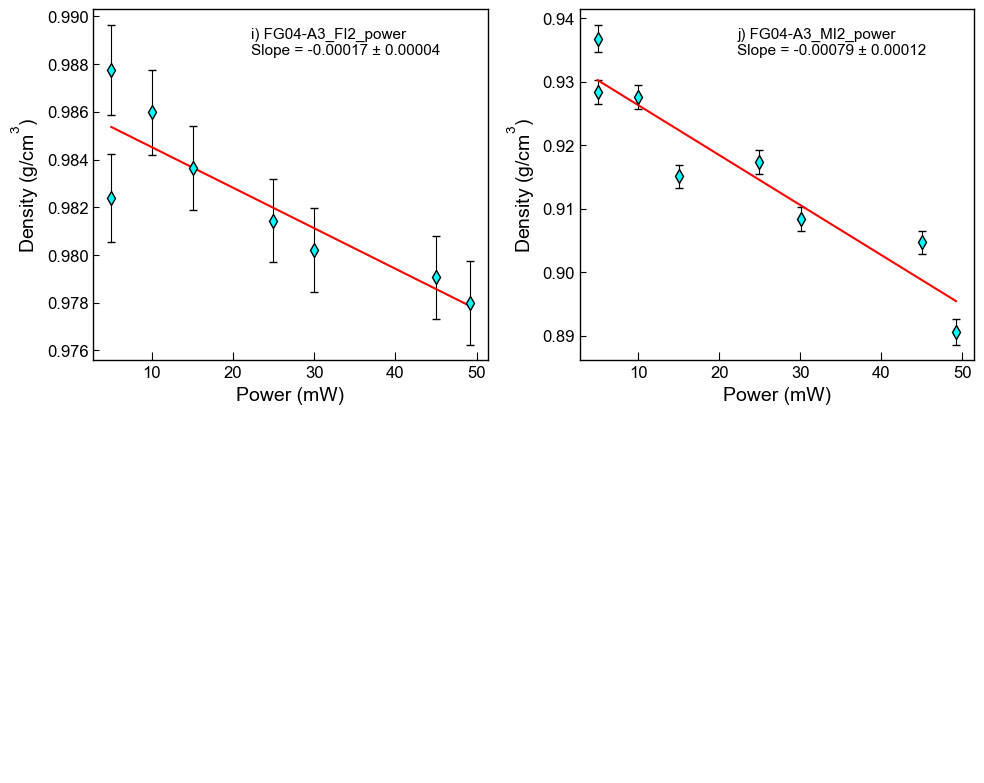

In [21]:
import string
import matplotlib.pyplot as plt
import numpy as np

labels_annotated = [f"{letter}) {label}" for letter, label in zip(string.ascii_lowercase, labels_power)]

# Break labels into chunks of 4 per figure
n_per_fig = 4
n_figs = int(np.ceil(len(labels_power) / n_per_fig))

for fig_num in range(n_figs):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Bigger panels
    axes = axes.flatten()
    
    for i in range(n_per_fig):
        index = fig_num * n_per_fig + i
        if index >= len(labels_power):
            axes[i].axis('off')
            continue
        
        label = labels_power[index]
        label_annotated = labels_annotated[index]
        ax = axes[i]
        
        subset = df_power[df_power['Series_Name'] == label]
        x = subset['power (mW)'].values
        y = subset['Density g/cm3'].values
        yerr = subset['σ Density g/cm3'].values

        # Plot errorbars
        ax.errorbar(x, y, yerr=yerr, fmt='d', ecolor='k', elinewidth=0.8,
                    mfc='cyan', ms=7, mec='k', capsize=3, label='Laser power')
        
        # Best fit line + gradient + uncertainty
        coeffs, cov = np.polyfit(x, y, 1, w=1/yerr, cov=True)
        slope, intercept = coeffs
        slope_err = np.sqrt(cov[0, 0])
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r-', label='Best fit')

        # Annotate slope
        annotation = f"{label_annotated}\nSlope = {slope:.5f} ± {slope_err:.5f}"
        ax.annotate(annotation, xy=(0.40, 0.95), xycoords='axes fraction',
                    fontsize=11, va='top', ha='left')

        ax.set_xlabel('Power (mW)')
        ax.set_ylabel('Density (g/cm$^3$)')

    fig.tight_layout()
    fig.savefig(f'Supplement_power_series_panel_{fig_num+1}.png', dpi=300)
    plt.show()


## Temperature effect

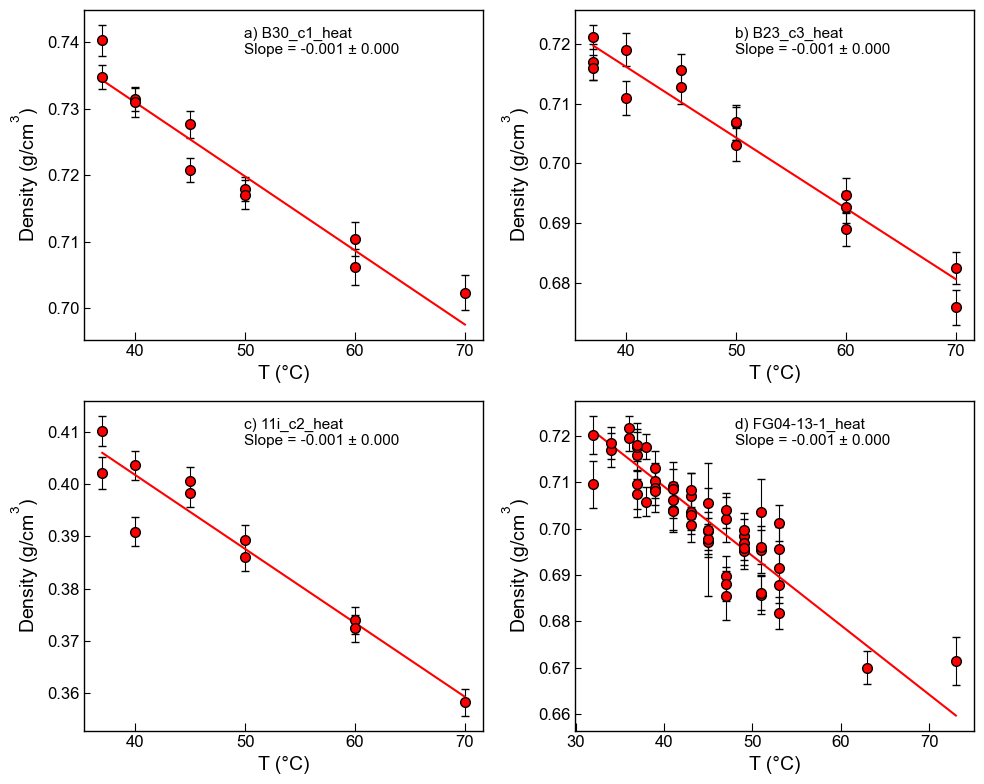

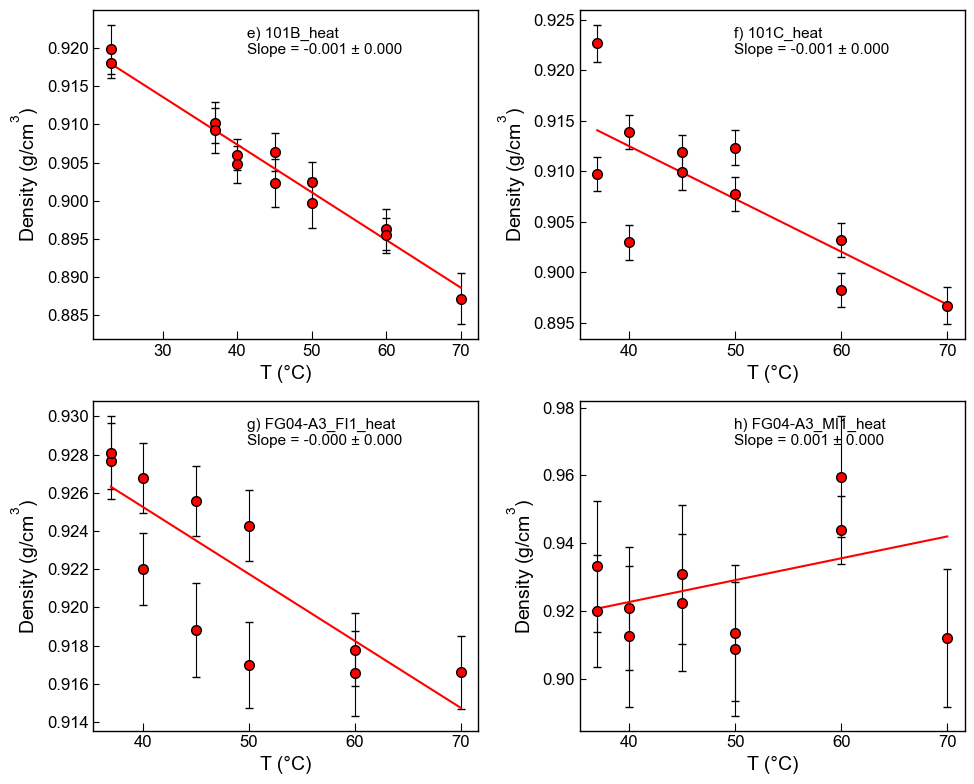

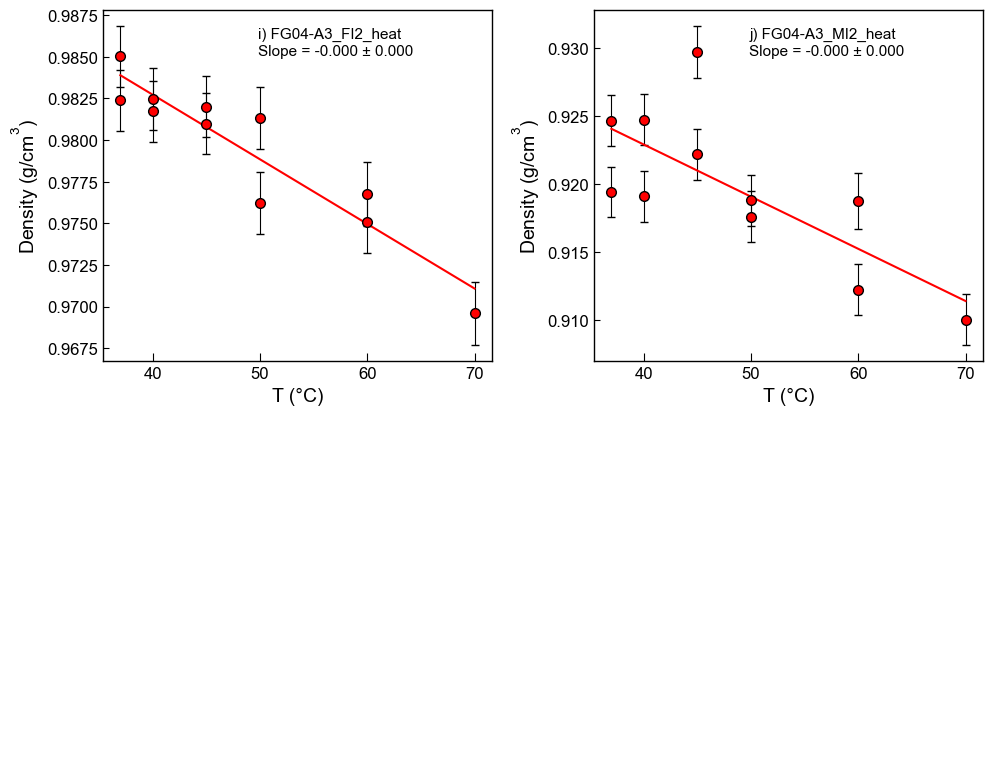

In [25]:
import string
import matplotlib.pyplot as plt
import numpy as np

# Annotated labels
labels_annotated = [f"{letter}) {label}" for letter, label in zip(string.ascii_lowercase, labels_heat)]

# Split into chunks of 4 panels per figure
n_per_fig = 4
n_figs = int(np.ceil(len(labels_heat) / n_per_fig))

for fig_num in range(n_figs):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Larger figure for 4 panels
    axes = axes.flatten()

    for i in range(n_per_fig):
        index = fig_num * n_per_fig + i
        if index >= len(labels_heat):
            axes[i].axis('off')
            continue

        label = labels_heat[index]
        label_annotated = labels_annotated[index]
        ax = axes[i]

        subset = df_heat[df_heat['Series_Name'] == label]
        x = subset['T (C)'].values
        y = subset['Density g/cm3'].values
        yerr = subset['σ Density g/cm3'].values

        # Plot red circles with error bars
        ax.errorbar(x, y, yerr=yerr,
                    fmt='o', ecolor='k', elinewidth=0.8,
                    mfc='red', mec='k', ms=7, capsize=3)

        # Best-fit line with uncertainty
        coeffs, cov = np.polyfit(x, y, 1, w=1/yerr, cov=True)
        slope, intercept = coeffs
        slope_err = np.sqrt(cov[0, 0])

        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r-', label='Best fit')

        # Annotate label and slope
        ax.annotate(f"{label_annotated}\nSlope = {slope:.3f} ± {slope_err:.3f}",
                    xy=(0.40, 0.95), xycoords='axes fraction',
                    fontsize=11, va='top', ha='left')

        ax.set_xlabel('T (°C)')
        ax.set_ylabel('Density (g/cm$^3$)')

    fig.tight_layout()
    fig.savefig(f'Supplement_heat_series_panel_{fig_num+1}.png', dpi=300)
    plt.show()
